In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import yaml

In [2]:
from auriga.snapshot import Snapshot
from auriga.images import figure_setup
from auriga.settings import Settings
from auriga.parser import parse

In [17]:
figure_setup()
settings = Settings()

In [4]:
def read_data(simulation: str, abundances: list, config: dict) -> pd.DataFrame:
    s = Snapshot(simulation=simulation, loadonlytype=[0, 1, 2, 3, 4, 5])
    s.tag_particles_by_region(
        disc_std_circ=config["DISC_STD_CIRC"],
        disc_min_circ=config["DISC_MIN_CIRC"],
        cold_disc_delta_circ=config["COLD_DISC_DELTA_CIRC"],
        bulge_max_specific_energy=config["BULGE_MAX_SPECIFIC_ENERGY"])
    for abundance in abundances:
        s.add_metal_abundance(of=abundance[0], to=abundance[1])

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)

    props = {"ComponentTag": s.region_tag[is_real_star & is_main_obj]}
    for abundance in abundances:
        of, to = abundance
        props[f"[{of}/{to}]"] = s.metal_abundance[f"{of}/{to}"][
            is_real_star & is_main_obj]

    df = pd.DataFrame(props)
    df[~np.isfinite(df)] = np.nan
    df.dropna(inplace=True)

    return df

## [O/Fe] vs. [Fe/H] (Sample)

In [ ]:
CONFIG_FILE = "02"
SAMPLE = [f"au{i}_or_l4_s127" for i in settings.groups["Included"]]

config = yaml.safe_load(open(f"../configs/{CONFIG_FILE}.yml"))

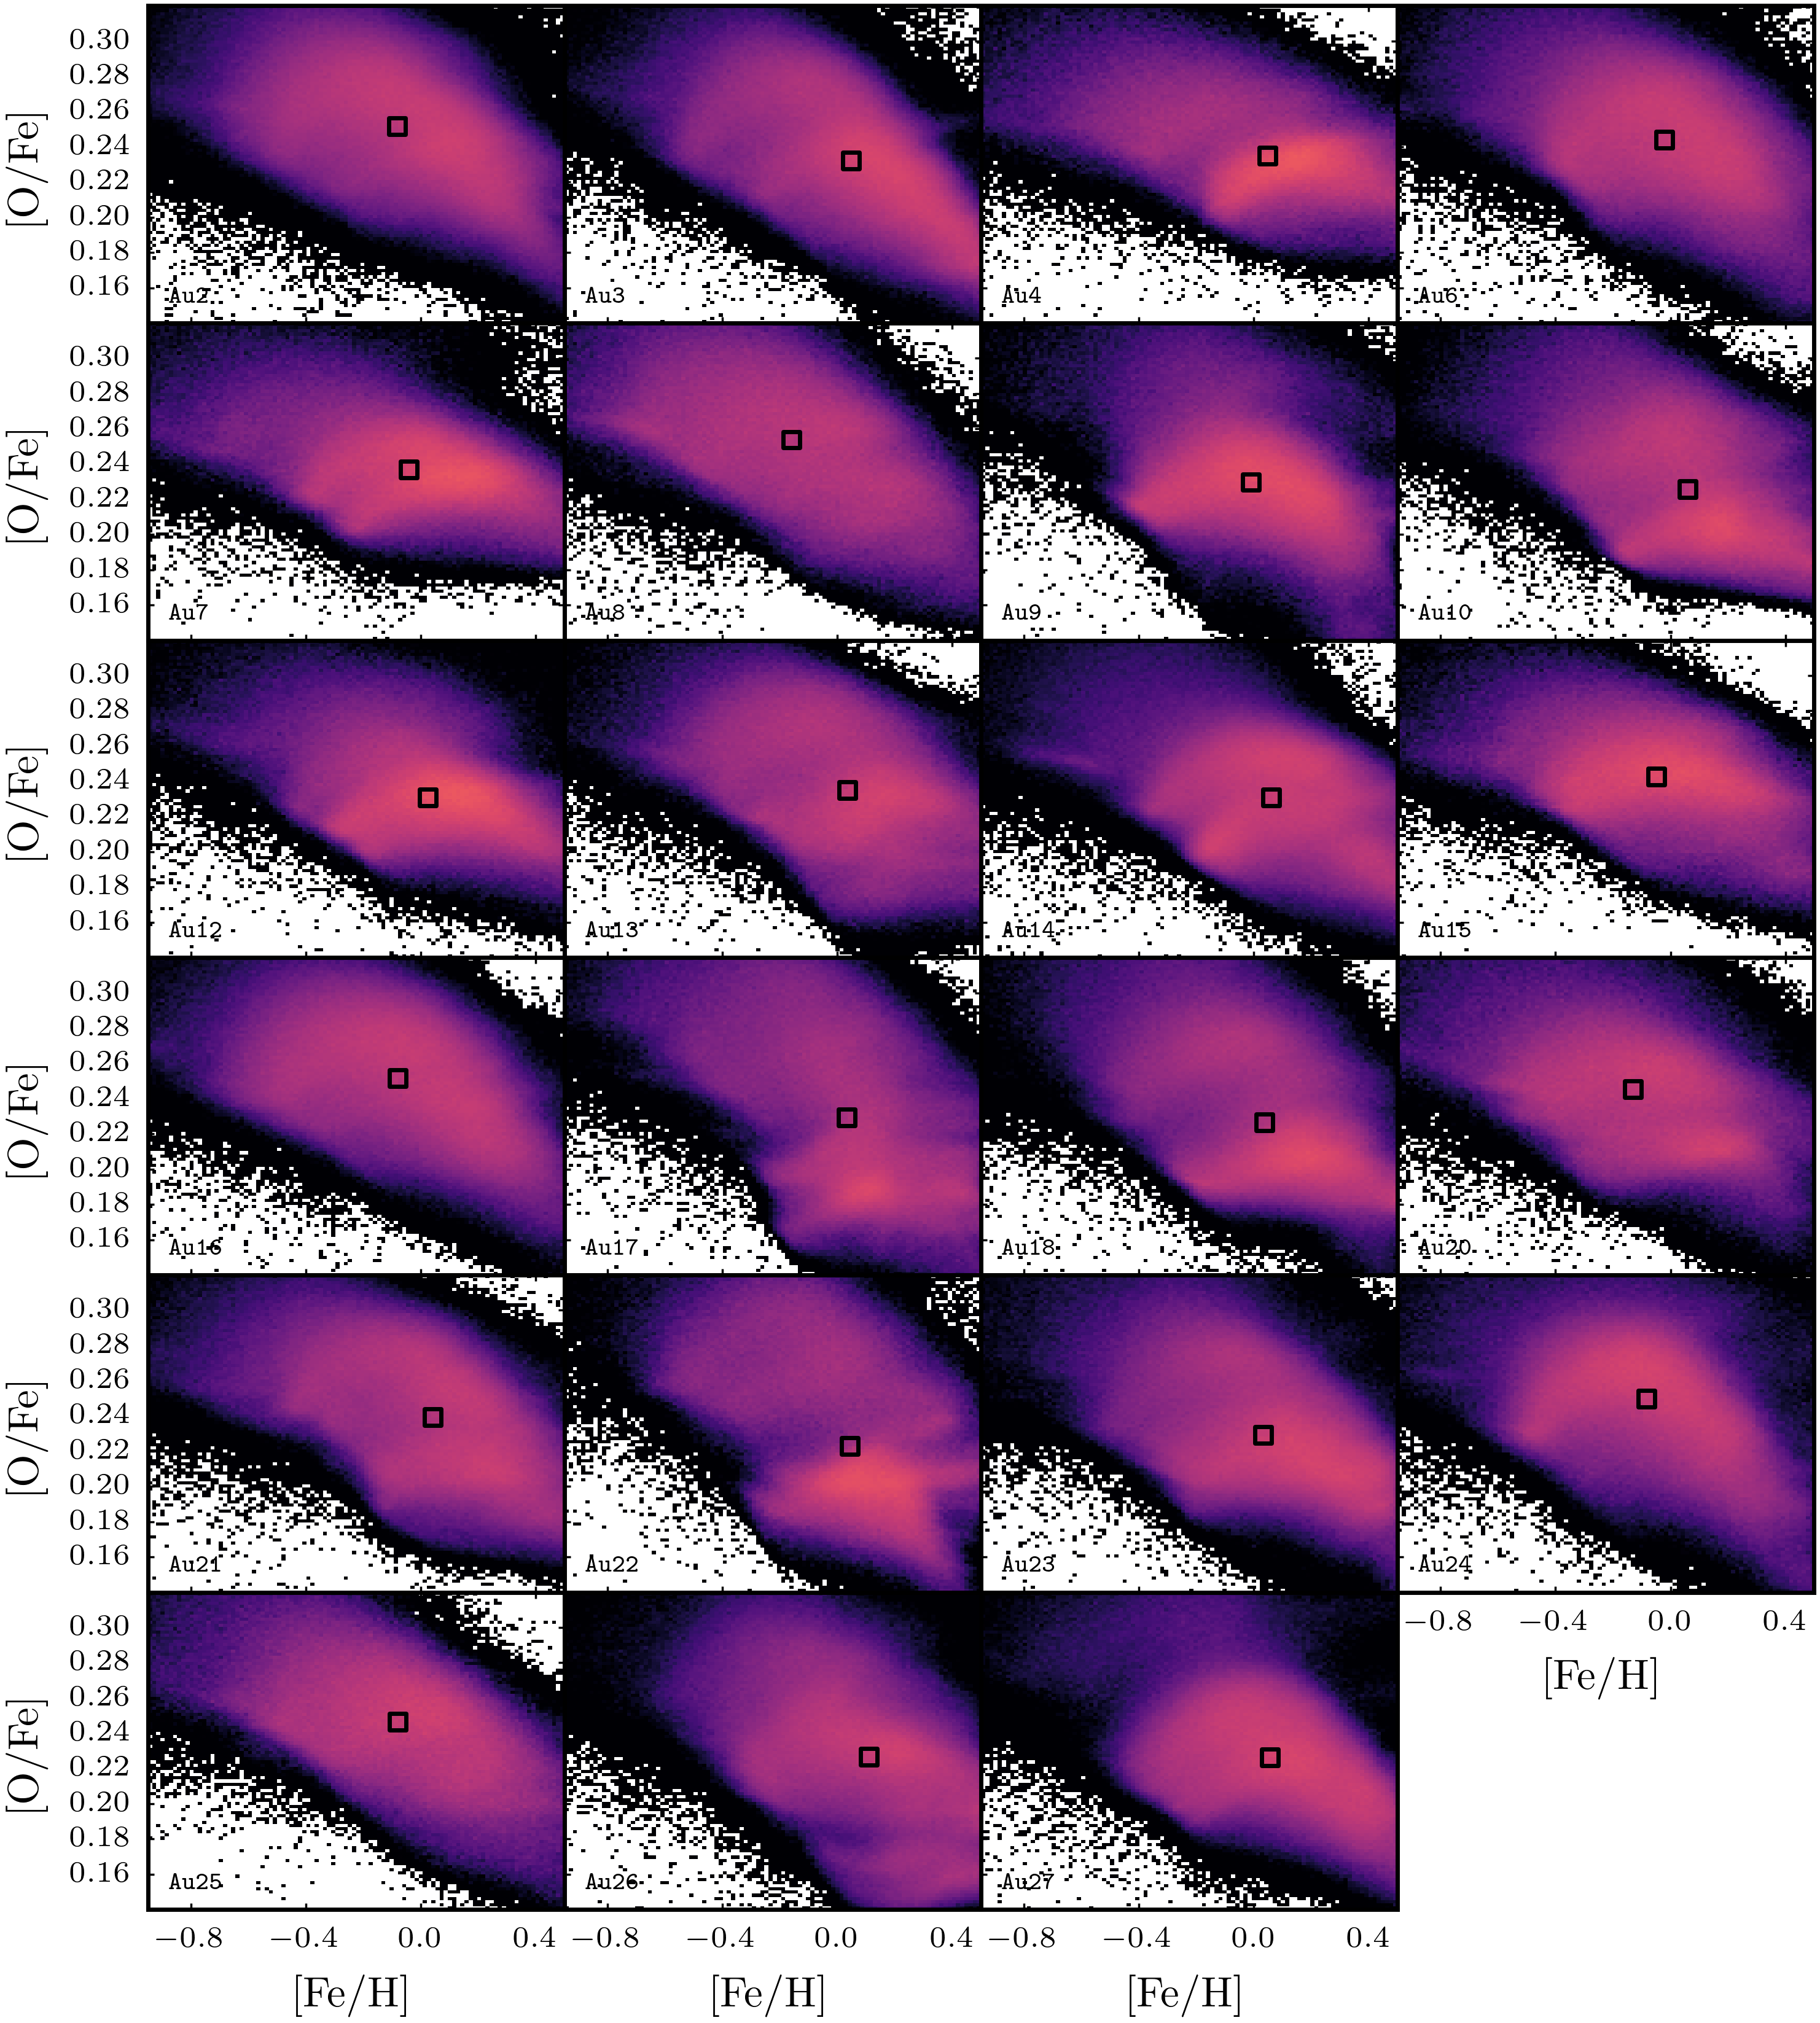

In [56]:
fig = plt.figure(figsize=(7, 8))
gs = fig.add_gridspec(nrows=6, ncols=4, hspace=0.0, wspace=0.0)
axs = gs.subplots(sharex=True, sharey=True)

for ax in axs.flatten():
    ax.tick_params(which='both', direction="in")
    if ax == axs[-1, -1]: ax.axis("off")
    ax.set_xlim(-0.95, 0.5)
    ax.set_xticks([-0.8, -0.4, 0, 0.4])
    ax.set_ylim(0.14, 0.32)
    ax.set_yticks([0.16, 0.18, 0.20, 0.22, 0.24, 0.26, 0.28, 0.30])
    ax.set_axisbelow(True)
    if ax.get_subplotspec().is_last_row() or ax == axs[-2, -1]:
        ax.set_xlabel("[Fe/H]")
        ax.tick_params(labelbottom=True)
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("[O/Fe]")
    ax.tick_params(axis='both', which='both', labelsize=7)

for i, simulation in enumerate(SAMPLE):
    ax = axs.flatten()[i]
    galaxy = parse(simulation)[0]
    label = f"Au{galaxy}"
    df = read_data(simulation=simulation,
                   abundances=[("O", "Fe"), ("Fe", "H")],
                   config=config)
    is_component = (df["ComponentTag"] == settings.component_tags["WD"]) \
        | (df["ComponentTag"] == settings.component_tags["CD"])

    H, xedges, yedges = np.histogram2d(
        x=df[is_component]["[Fe/H]"],
        y=df[is_component]["[O/Fe]"],
        bins=100, range=[ax.get_xlim(), ax.get_ylim()],
        weights=1 / is_component.sum() * np.ones(len(df[is_component]))
    )
    ax.pcolormesh(xedges, yedges, H.T, cmap='magma',
                  norm=mcolors.LogNorm(vmin=1E-5, vmax=1E-2))
    median = (df[is_component]["[Fe/H]"].median(),
              df[is_component]["[O/Fe]"].median())
    ax.scatter(median[0], median[1], c='k', s=15, lw=1, marker='s', fc='none',
               ec='k', zorder=15, transform=ax.transData)

    ax.text(x=0.05, y=0.05, s=r"$\texttt{" + label + "}$",
            size=6.0, transform=ax.transAxes, ha='left', va='bottom')

plt.show()

## [O/Fe] Distribution (Sample)

In [ ]:
CONFIG_FILE = "02"
SAMPLE = [f"au{i}_or_l4_s127" for i in settings.groups["Included"]]

config = yaml.safe_load(open(f"../configs/{CONFIG_FILE}.yml"))

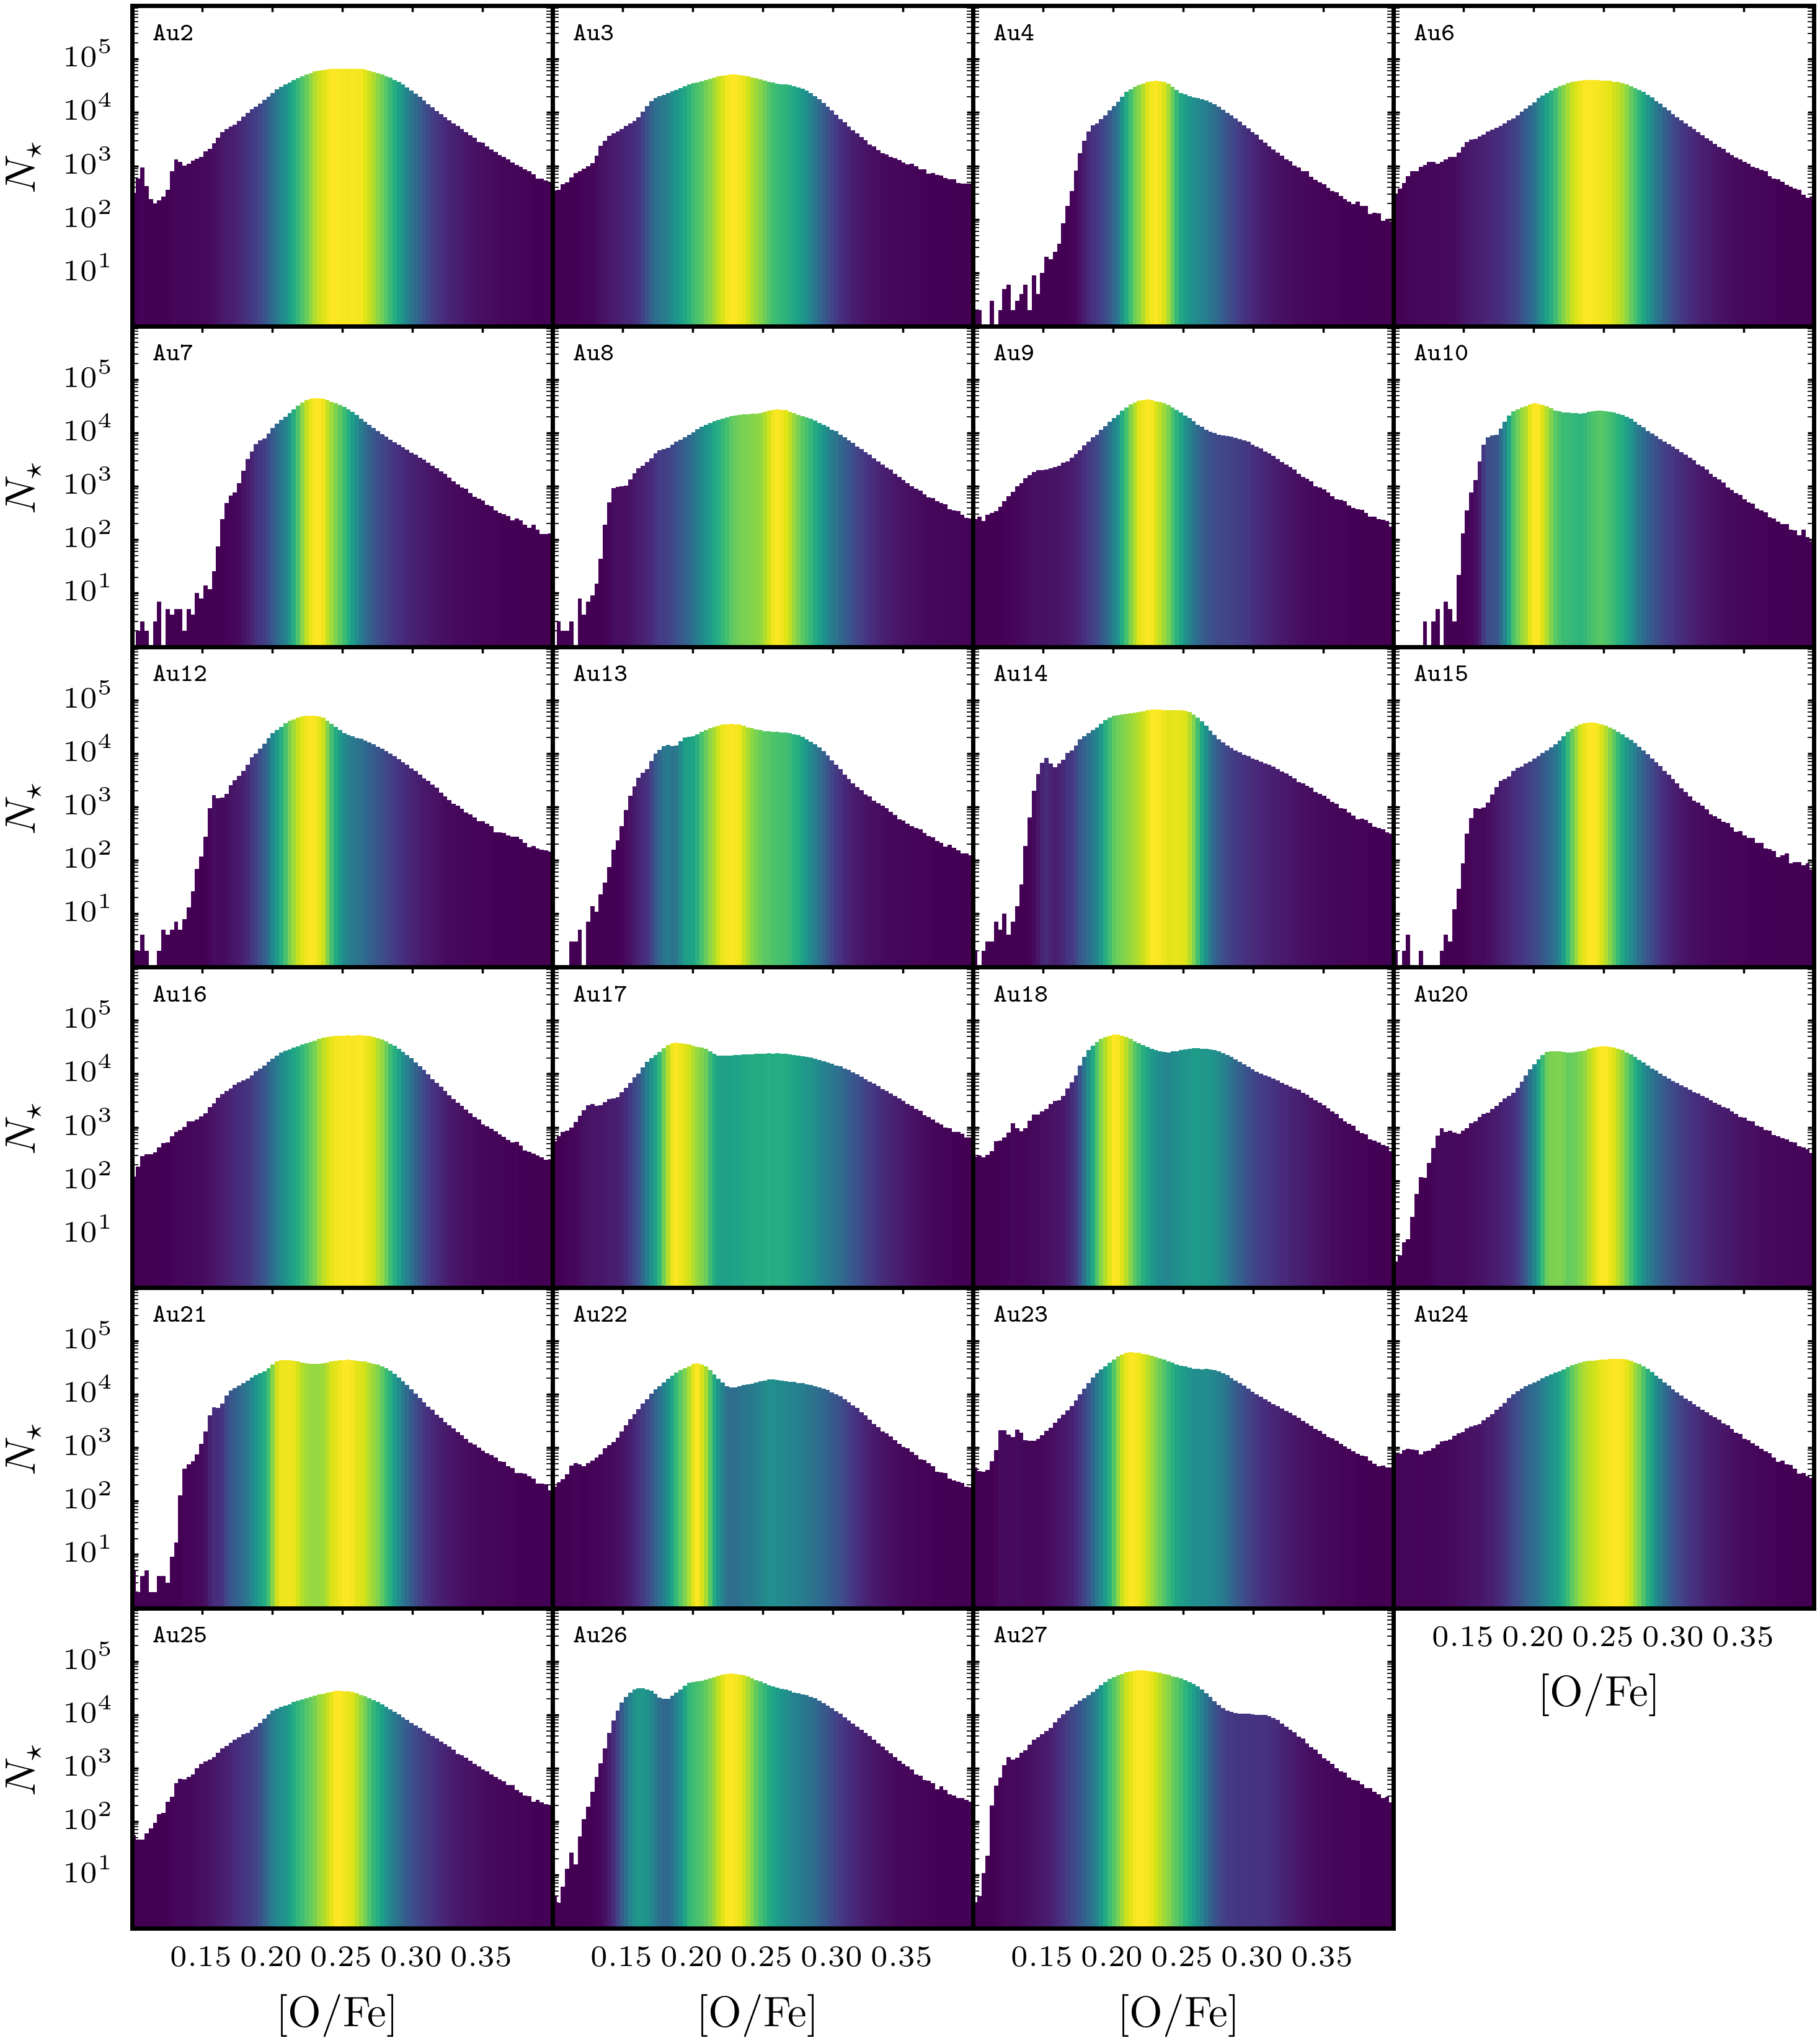

In [77]:
fig = plt.figure(figsize=(7, 8))
gs = fig.add_gridspec(nrows=6, ncols=4, hspace=0.0, wspace=0.0)
axs = gs.subplots(sharex=True, sharey=True)

for ax in axs.flatten():
    ax.tick_params(which='both', direction="in")
    if ax == axs[-1, -1]: ax.axis("off")
    ax.set_xlim(0.1, 0.4)
    ax.set_xticks([0.15, 0.20, 0.25, 0.30, 0.35])
    ax.set_ylim(1E0, 1E6)
    ax.set_yscale("log")
    ax.set_yticks([1E1, 1E2, 1E3, 1E4, 1E5])
    ax.set_axisbelow(True)
    if ax.get_subplotspec().is_last_row() or ax == axs[-2, -1]:
        ax.set_xlabel("[O/Fe]")
        ax.tick_params(labelbottom=True)
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(r"$N_\star$")
    ax.tick_params(axis='both', which='both', labelsize=7)


for i, simulation in enumerate(SAMPLE):
    ax = axs.flatten()[i]
    galaxy = parse(simulation)[0]
    label = f"Au{galaxy}"
    df = read_data(simulation=simulation,
                   abundances=[("O", "Fe")],
                   config=config)
    is_component = (df["ComponentTag"] == settings.component_tags["WD"]) \
        | (df["ComponentTag"] == settings.component_tags["CD"])

    N, bins, patches = ax.hist(
        x=df[is_component]["[O/Fe]"], bins=100, range=ax.get_xlim(),
        linewidth=0,
        )
    fracs = N / N.max()
    norm = mcolors.Normalize(fracs.min(), fracs.max())
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)

    ax.text(x=0.05, y=0.95, s=r"$\texttt{" + label + "}$",
            size=6.0, transform=ax.transAxes, ha='left', va='top')

plt.show()